# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Importing Relevant libraries

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Read in json files

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Portfolio data

In [3]:
#size of portfolio json file
portfolio.shape

(10, 6)

In [4]:
#view data
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [5]:
#explore distribution of offer types
portfolio['offer_type'].value_counts()

offer_type
bogo             4
discount         4
informational    2
Name: count, dtype: int64

In [6]:
#column data type
portfolio.dtypes

reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object

### Profile data

In [7]:
#size of data
profile.shape

(17000, 5)

In [8]:
#explore contents of data
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [9]:
#field data types
profile.dtypes

gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object

### Transcript data

In [10]:
#size of data
transcript.shape

(306534, 4)

In [11]:
#explore contents of data
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


#### Exploring the value Column

The value column in the transcript.json file is a dictionary that can contain different keys based on the event type:


- Transaction Event:
The value column contains amount, which represents the transaction amount.

- ID Event:
The value column contains the key offer_id, which represents the ID of the received offer, viewed offer or completed offer.

In [12]:
#exploring distinct value types
transcript['value'].value_counts()

value
{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}    14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}    14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}    14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}    14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}    14374
                                                    ...  
{'amount': 42.31}                                       1
{'amount': 44.62}                                       1
{'amount': 42.27}                                       1
{'amount': 108.89}                                      1
{'amount': 476.33}                                      1
Name: count, Length: 5121, dtype: int64

In [13]:
# Extract relevant information from the 'value' column - as it is a dictionary value type
transcript['amount'] = transcript['value'].apply(lambda x: x['amount'] if 'amount' in x else None)
transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer_id'] if 'offer_id' in x else None)

In [14]:
# Drop the original 'value' column as it's no longer needed
transcript.drop(columns=['value'], inplace=True)

## Data Cleaning

### Exploring missing values

In [15]:
#percentage of nulls per column for portfolio data
most_missing_cols = portfolio.isnull().mean() * 100
most_missing_cols

reward        0.0
channels      0.0
difficulty    0.0
duration      0.0
offer_type    0.0
id            0.0
dtype: float64

In [16]:
#percentage of nulls per column for portfolio data
most_missing_cols1 = profile.isnull().mean() * 100
most_missing_cols1

gender              12.794118
age                  0.000000
id                   0.000000
became_member_on     0.000000
income              12.794118
dtype: float64

In [17]:
# Convert 'became_member_on' to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [18]:
#percentage of nulls per column for portfolio data
most_missing_cols2 = transcript.isnull().mean() * 100
most_missing_cols2
#very few records have null values so they can be dropped

person       0.000000
event        0.000000
time         0.000000
amount      54.669629
offer_id    89.045587
dtype: float64

Portfolio data doesn't have missing values, therefore we do not need to impute anything there. However, profile data has missing values in the gender (12,79%) and income (12,79%) columns; on the same hand, transcription data has amount (54,67%) and offer_id (89,05%) of missing data. We might need to impute some missing data here

### Imputing missing values

In [19]:
# Handle missing values in profile data
profile['gender'].fillna('O', inplace=True)
profile['income'].fillna(profile['income'].median(), inplace=True)

In [20]:
#distribution of gender
profile['gender'].value_counts()

gender
M    8484
F    6129
O    2387
Name: count, dtype: int64

In [21]:
transcript.head()

,person,event,time,amount,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,None
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,None
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,None
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,None
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,None


In [22]:
#imputing missing values in transcript data
transcript['amount'].fillna(0, inplace=True)
transcript['offer_id'].fillna('None', inplace=True)

## Merging of dataframes

In [22]:
# Merge profile and transcript on 'person'
join_df = pd.merge(transcript, profile, left_on='person', right_on='id', how='left')

In [23]:
# Merge the resulting DataFrame with portfolio on 'value' (offer_id)
join_df1 = pd.merge(join_df, portfolio, left_on='offer_id', right_on='id', how='left')

In [24]:
#determining size of dataframe
join_df1.shape

(306534, 16)

In [25]:
#dropping duplicate columns
join_df1 = join_df1.drop(['id_x','id_y'],axis=1)

In [26]:
join_df1.head()

,person,event,time,amount,offer_id,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,None,F,75,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,None,O,118,2017-08-04,64000.0,NaN,NaN,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,None,M,68,2018-04-26,70000.0,NaN,NaN,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,None,O,118,2017-09-25,64000.0,NaN,NaN,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,None,O,118,2017-10-02,64000.0,NaN,NaN,NaN,NaN,NaN


In [27]:
# Feature Engineering
# Create a new column to indicate if an offer was viewed
join_df1['offer_viewed'] = join_df1['event'].apply(lambda x: 1 if x == 'offer viewed' else 0)

# Create a new column to indicate if an offer was completed
join_df1['offer_completed'] = join_df1['event'].apply(lambda x: 1 if x == 'offer completed' else 0)

In [29]:
join_df1.head()

,person,event,time,amount,offer_id,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type,offer_viewed,offer_completed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,None,F,75,2017-05-09,100000.0,NaN,NaN,NaN,NaN,NaN,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,None,O,118,2017-08-04,64000.0,NaN,NaN,NaN,NaN,NaN,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,None,M,68,2018-04-26,70000.0,NaN,NaN,NaN,NaN,NaN,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,None,O,118,2017-09-25,64000.0,NaN,NaN,NaN,NaN,NaN,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,None,O,118,2017-10-02,64000.0,NaN,NaN,NaN,NaN,NaN,0,0


In [30]:
join_df1['gender'].value_counts()

gender
M    155690
F    113101
O     37743
Name: count, dtype: int64

In [31]:
37743/306534 #% of other

0.12312826635870736

In [32]:
155690/306534 #% of males

0.5079045065147749

In [33]:
155690+113101+37743

306534

## Exploratory Data Analysis

### General Analysis on data set

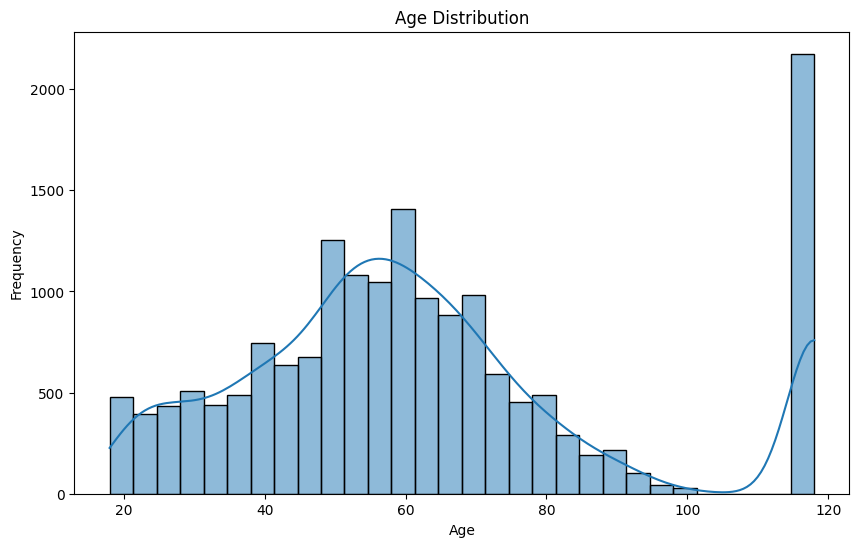

In [34]:
# Plot the distribution of demographic variables
plt.figure(figsize=(10, 6))
sns.histplot(profile['age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

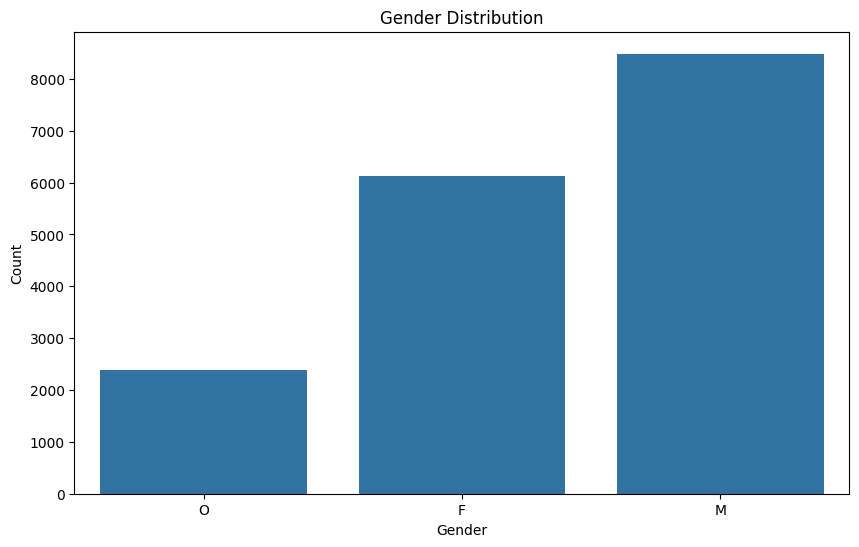

In [35]:
plt.figure(figsize=(10, 6))
sns.countplot(x='gender', data=profile)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

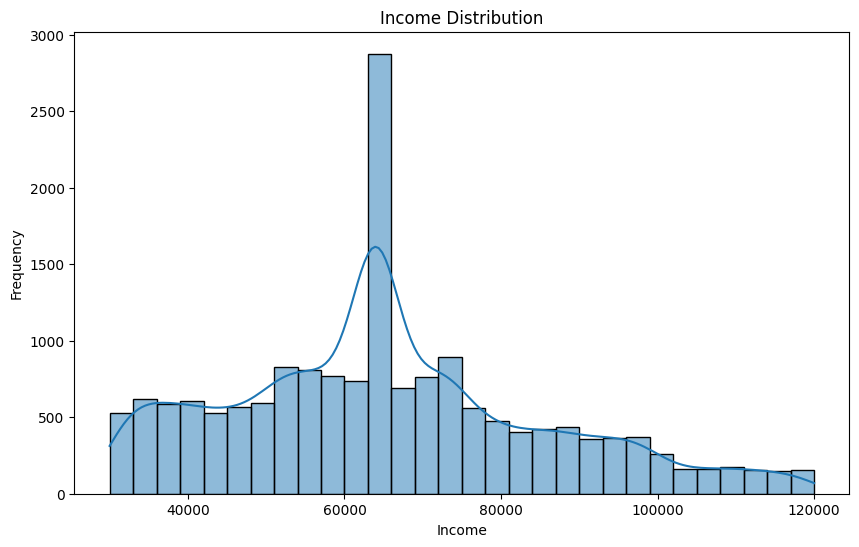

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(profile['income'], bins=30, kde=True)
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()

### Answering the main Question: Combine transaction, demographic and offer data to determine which demographic groups respond to which offer type

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

In [39]:
#not_null_mask = join_df1.notnull().all(axis=1)
#not_null_rows = join_df1[not_null_mask]

In [40]:
#not_null_rows['channels'].value_counts()

channels
[web, email, mobile, social]    18100
[web, email, mobile]             8371
[email, mobile, social]          3688
[web, email]                     3420
Name: count, dtype: int64

### Insights Analysis for Age

#### Offer Type Preferences by Age

In [38]:
#distribution of offer completed column
join_df1['offer_completed'].value_counts()

offer_completed
0    272955
1     33579
Name: count, dtype: int64

In [56]:
# Analyze offer type preferences by age
offer_preferences_by_age = join_df1.groupby(['age', 'offer_type'])['offer_completed'].count().reset_index()

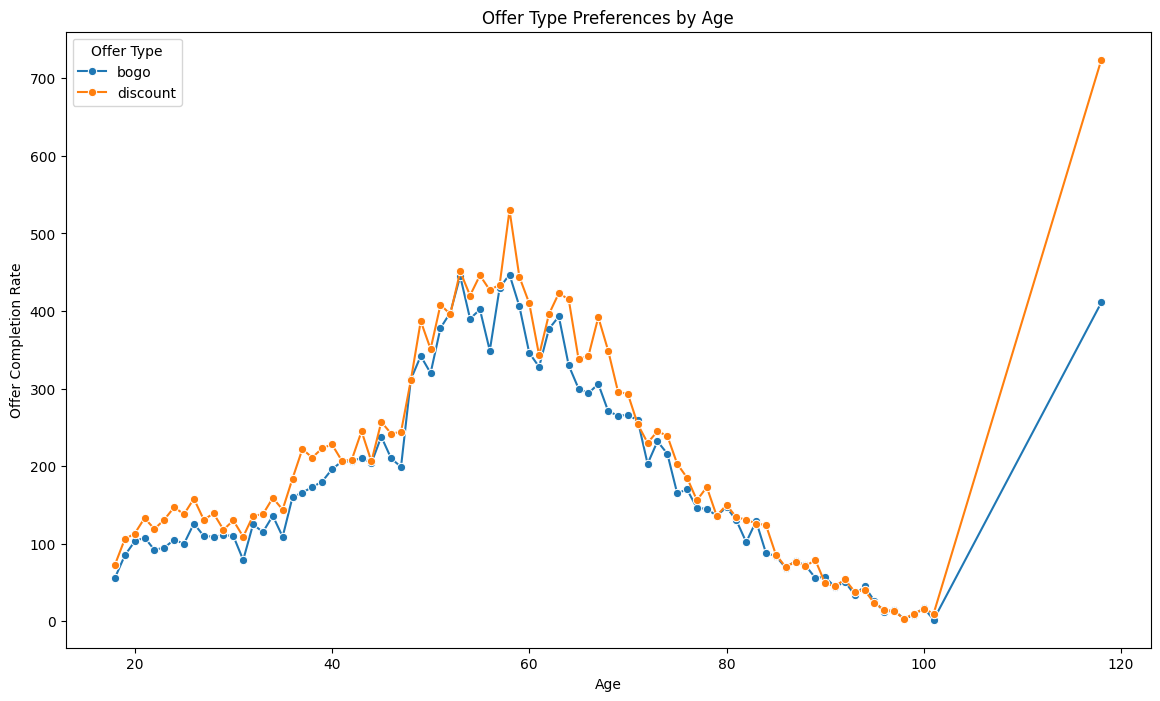

In [41]:
# Plot offer type preferences by age
plt.figure(figsize=(14, 8))
sns.lineplot(x='age', y='offer_completed', hue='offer_type', data=offer_preferences_by_age, marker='o')
plt.title('Offer Type Preferences by Age')
plt.xlabel('Age')
plt.ylabel('Offer Completion Rate')
plt.legend(title='Offer Type')
plt.show()

#### Age Group Bands

In [57]:
# Define age groups
bins = [0, 25, 45, 100]
labels = ['Young Adults (18-25)', 'Middle-Aged Adults (26-45)', 'Older Adults (46+)']
join_df1['age_group'] = pd.cut(join_df1['age'], bins=bins, labels=labels, right=False)

In [58]:
#distribution of age group bands
join_df1['age_group'].value_counts()

age_group
Older Adults (46+)            192012
Middle-Aged Adults (26-45)     63364
Young Adults (18-25)           17054
Name: count, dtype: int64

In [46]:
# Debugging Step: Check the distribution of offer_completed
print("Distribution of offer_completed:")
print(join_df1['offer_completed'].value_counts())

Distribution of offer_completed:
offer_completed
0    272955
1     33579
Name: count, dtype: int64


In [49]:
# Analyze offer type preferences by age group
offer_preferences_by_age_group = join_df1.groupby(['age_group','offer_type'])['offer_completed'].count().reset_index()
offer_preferences_by_age_group

/tmp/ipykernel_68/1088125525.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  offer_preferences_by_age_group = join_df1.groupby(['age_group','offer_type'])['offer_completed'].count().reset_index()


,age_group,offer_type,offer_completed
0,Young Adults (18-25),bogo,644
1,Young Adults (18-25),discount,822
2,Middle-Aged Adults (26-45),bogo,2932
3,Middle-Aged Adults (26-45),discount,3434
4,Older Adults (46+),bogo,11663
5,Older Adults (46+),discount,12904


In [61]:
822/(644+822)#bogo young adults

0.5607094133697135

In [62]:
3434/(2932+3434) #bogo middle aged

0.5394282123782596

In [63]:
12904/(11663+12904) #discount older adults

0.5252574591932266

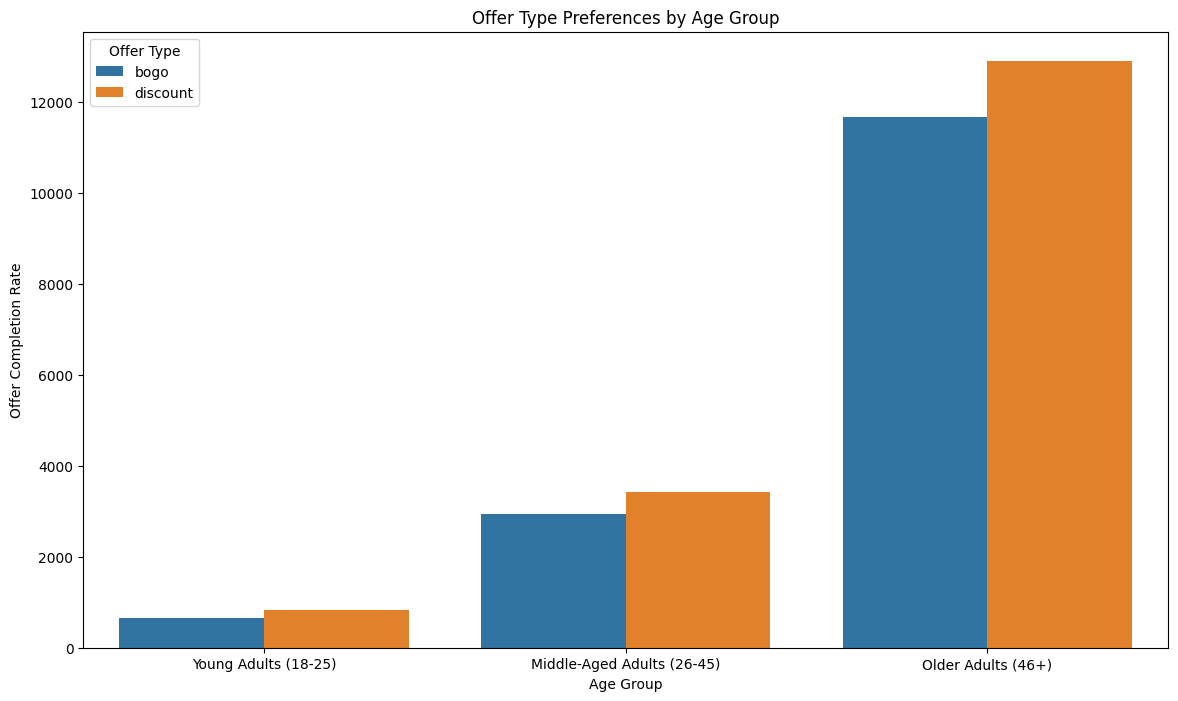

In [59]:
# Plot offer type preferences by age group
plt.figure(figsize=(14, 8))
sns.barplot(x='age_group', y='offer_completed', hue='offer_type', data=offer_preferences_by_age_group)
plt.title('Offer Type Preferences by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Offer Completion Rate')
plt.legend(title='Offer Type')
plt.show()

#### Age Group Analysis by Channel Preference

In [52]:
# Explode the 'channels' column into separate rows
channels_df = join_df1.explode('channels')

In [54]:
# Calculate engagement rates by age group and channel
engagement_by_channel = channels_df.groupby(['age_group', 'channels'])['offer_completed'].count().reset_index()
engagement_by_channel

/tmp/ipykernel_68/3956806521.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  engagement_by_channel = channels_df.groupby(['age_group', 'channels'])['offer_completed'].count().reset_index()


,age_group,channels,offer_completed
0,Young Adults (18-25),email,1466
1,Young Adults (18-25),mobile,1331
2,Young Adults (18-25),social,958
3,Young Adults (18-25),web,1336
4,Middle-Aged Adults (26-45),email,6366
5,Middle-Aged Adults (26-45),mobile,5785
6,Middle-Aged Adults (26-45),social,4179
7,Middle-Aged Adults (26-45),web,5683
8,Older Adults (46+),email,24567
9,Older Adults (46+),mobile,21900


In [64]:
1466/(1466+1331+958+1336) #email young adults

0.28795914358672164

In [65]:
6366/(6366+5785+4179+5683) #email middle-aged

0.2891927497387907

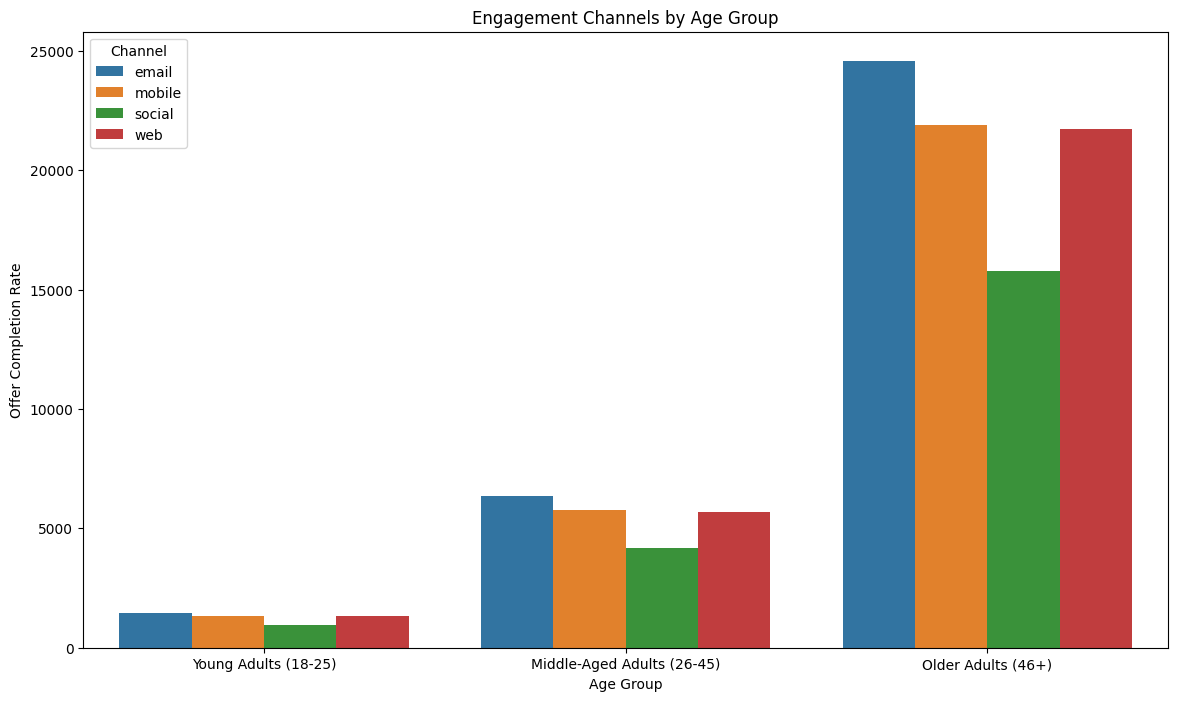

In [66]:
# Analyze engagement channels by age group
# Plot engagement channels by age group
plt.figure(figsize=(14, 8))
sns.barplot(x='age_group', y='offer_completed', hue='channels', data=engagement_by_channel)
plt.title('Engagement Channels by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Offer Completion Rate')
plt.legend(title='Channel')
plt.show()

### Gender

#### Offer Preferences by Gender

In [38]:
# Analyze response rates to different offer types across demographic groups
response_rates = join_df1.groupby(['gender', 'offer_type'])['offer_completed'].count().reset_index()
print(response_rates)

  gender offer_type  offer_completed
0      F       bogo             7501
1      F   discount             7976
2      M       bogo             7512
3      M   discount             8954
4      O       bogo              656
5      O   discount              980


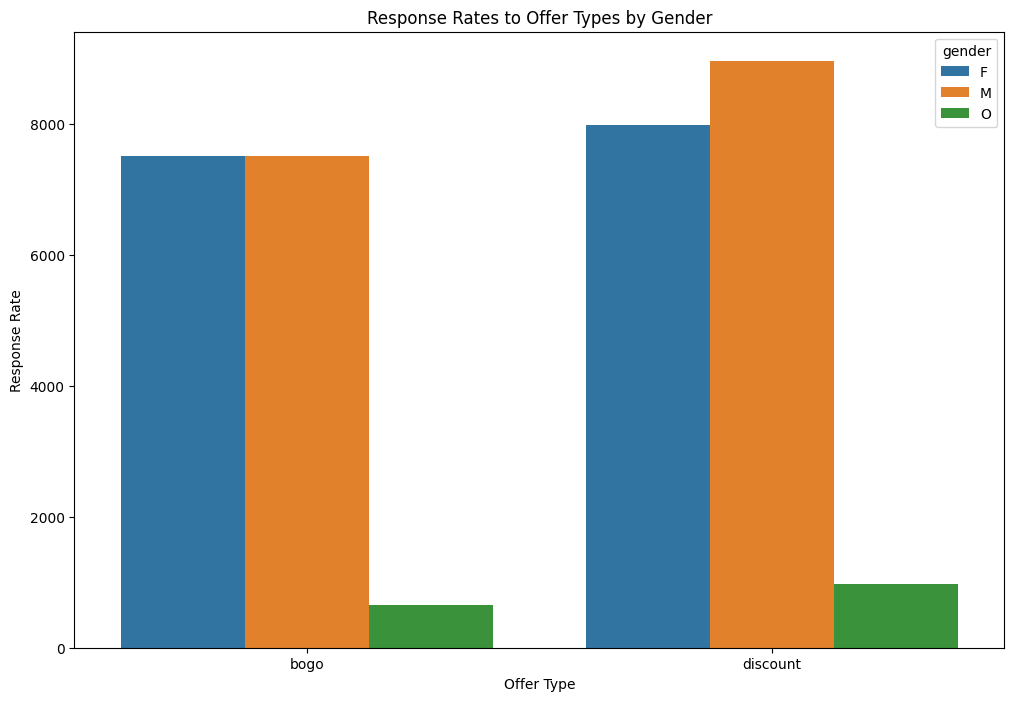

In [39]:
# Plot response rates
plt.figure(figsize=(12, 8))
sns.barplot(x='offer_type', y='offer_completed', hue='gender', data=response_rates)
plt.title('Response Rates to Offer Types by Gender')
plt.xlabel('Offer Type')
plt.ylabel('Response Rate')
plt.show()

In [47]:
# Analyze response rates to different offer types across demographic groups
response_rates = join_df1.groupby(['gender'])['offer_type'].count().reset_index()
print(response_rates)

  gender  offer_type
0      F       15477
1      M       16466
2      O        1636


In [71]:
# Analyze response rates to different offer types across demographic groups
response_rates = join_df1.groupby(['gender'])['income'].mean().reset_index()
print(response_rates)

  gender        income
0      F  69546.750250
1      M  60589.087289
2      O  63884.031476


### Insights

- Young Adults (18-25):
May prefer BOGO offers as they often look for value deals.
Higher engagement with mobile and social channels.

- Middle-Aged Adults (26-45):
May respond well to discount offers, especially those tied to higher spending thresholds.
Likely to engage with email and web channels.

- Older Adults (46+):
May prefer informational offers that provide details about new products or services.
Higher engagement with email and in-app notifications.